# Air Temperature Forcing 


In order to initialize our synthetic glaciers we need climate forcing data which is broadly representative of where the template glaciers are located. 


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

Let's load the Kaskawulsh zero net-balance reults from Kaite's using the model from Young et al. 2021. 

In [2]:
nc_fp = "../input_data/mass_balance/Kaskawulsh_NetBalance.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    DOY_mean = MB_new["Temp-GWA"].groupby("time.dayofyear").mean()
    DOY_std  = MB_new["Temp-GWA"].groupby("time.dayofyear").std()

## Air Temperature 

First, let's just look at the air temperature as a function of day of year (DOY). We'll look at each individual year the model was run (2007--2018) and the average daily temperature over the whole model run. 

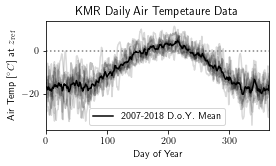

In [15]:
def plot_observations():
    fig, ax = plt.subplots(figsize=(4, 2))

    for year in np.arange(2007, 2019):
        yearly = MB_new.isel(time=MB_new.time.dt.year==year)

        if year == 2018: 
            ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], 
                    color='k', alpha=0.25) #, label='2007--2018')
        else: 
            ax.plot(yearly.time.dt.dayofyear, yearly["Temp-GWA"], color='k', alpha=0.15)

    ax.plot(DOY_mean.dayofyear, DOY_mean, color='k', 
             label='2007-2018 D.o.Y. Mean')

    ax.axhline(0.0, ls=':', color='grey')
    
    ax.legend(loc=8)

    ax.set_title('KMR Daily Air Tempetaure Data')
    ax.set_xlabel('Day of Year')
    ax.set_ylabel(r'Air Temp [$^\circ C$] at $z_{\rm ref}$ ') #\approx $ 2200 m a.s.l.');
    
    ax.set_xlim(0,365)
    
    return fig, ax 

plot_observations();

A couple things jump out initially. First, the data is annual data noisy and the daily mean does not capture the random variability in the data. Second, the random variability is not constant in time; it appears to be greater in the winter months as compared to the height of the melt season. These will be important things to consider as we try to fit a forward model to this data. 

### Parameter Estimation 

Now, lets fit a forward model to the model results. We will use the standard approximation of the annual temperature: 
$$
\begin{align} \label{eq:airtempfull}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma} + (z - z_{\rm ref}) \frac{d T}{dz} ,
\end{align} 
$$
where:
- $\alpha$ is the annual air temperature amplitude (K), 
- $T_{\rm ma}$ is the mean annual air temperature at reference elevation $z_{\rm ref}$ (K) ,
- $\frac{d T}{dz}$ is the atmospheric lapse rate (K m$^{-1}$),
- $\hat{T}$ is the DOY of air temperature peak (d).

Since only the domain averaged daily temperature is only provided we are interested in the elevation dependence of the air temperature (third term in above equation). Therefore, our forward model simplifies to:
$$
\begin{equation}
    T(d,z) = \alpha \cos\left( \frac{2 \pi \left(d - \hat{T} \right) }{365} \right) + T_{\rm ma},
\end{equation} 
$$
where $\alpha$, $T_{\rm ma}$, $\hat{T}$, are the unknown parameters we seek to determine.


To determine the unknown parameters let's use non-linear least squares. So, let's define a model class which we can for both fitting and forward model evaluation. 

In [4]:
from scipy import optimize

class AirTemp:
    
    def __init__(self, T_obs): 
        
        if T_obs.size in [365, 366]: 
            self.T_obs = T_obs
            self.doy   = np.arange(1,T_obs.size+1)
        else: 
            raise ValueError('T_obs must be of size 365 or 366')
        
    def forward(self, p): 
        T = p[0] * np.cos(2 * np.pi * (self.doy - p[1]) / self.doy.size) + p[2] 
        return T

    def __cost(self, p): 
        return self.forward(p) - self.T_obs
    
    def fit(self, p0, loss='soft_l1'): 
        res_lsq = optimize.least_squares(self.__cost, p0, loss=loss)
        return res_lsq

Next, let's initialize our class, fit and evaluate our model.  

In [5]:
# initalize the model with observations
Temp_model = AirTemp(DOY_mean)
# fit the model with a first guess at the unknown params
res_lstq   = Temp_model.fit(p0=[10,193,-8])
# evaluate the forward model based on fitted param values
predicted  = Temp_model.forward(res_lstq.x)

Next let's visualize the results. 

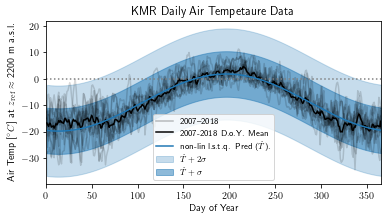

In [6]:

fig, ax = plot_observations();
         
ax.plot(DOY_mean.dayofyear, predicted, 
        label=r'non-lin l.s.t.q. Pred ($\hat T$).')

KMR_std = float(MB_new["Temp-GWA"].std())

ax.fill_between(DOY_mean.dayofyear, 
                predicted-2*KMR_std, 
                predicted+2*KMR_std, 
                alpha=0.25, color='tab:blue', 
                label='$\hat T + 2 \sigma$')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-KMR_std, 
                predicted+KMR_std,
                alpha=0.5, color='tab:blue',
                label='$\hat T + \sigma$')

ax.legend(fontsize='small', loc=8)

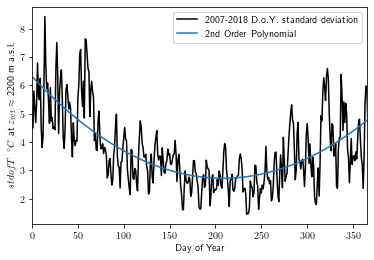

In [7]:
fig, ax = plt.subplots()

ax.plot(DOY_mean.dayofyear, DOY_std, color='k', 
         label='2007-2018 D.o.Y. standard deviation')

p = np.polyfit(DOY_mean.dayofyear, DOY_std, 2)

ax.plot(DOY_mean.dayofyear, 
        np.polyval(p, DOY_mean.dayofyear),
        label='2nd Order Polynomial')

ax.set_xlim(0,365)
ax.legend()
ax.set_xlabel('Day of Year')
ax.set_ylabel(r'$std of T \;\; ^\circ C$ at $z_{\rm ref} \approx $ 2200 m a.s.l.');

In [8]:
p = np.polyfit(DOY_mean.dayofyear, DOY_std, 2)
fancy_std = np.polyval(p, DOY_mean.dayofyear)

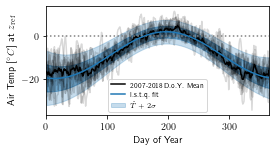

In [20]:
fig, ax = plot_observations();


ax.plot(DOY_mean.dayofyear, predicted, 
        label=r'l.s.t.q. fit')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-2*fancy_std, predicted+2*fancy_std, 
                alpha=0.25, color='tab:blue', 
                label='$\hat T + 2 \sigma$')

ax.fill_between(DOY_mean.dayofyear, 
                predicted-fancy_std, predicted+fancy_std,
                alpha=0.5, color='tab:blue',
               )#label='$\hat T + \sigma$')

ax.set_title(None)
ax.legend(fontsize='x-small', loc=8);

fig.savefig('./AirTempFit.png', dpi=600, bbox_inches='tight', facecolor='w')

## Mass Balance 

### Spline fitting 